# Load Dependencies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# MIT-BIH Arrythmia Dataset

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
    Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
    The final element of each row denotes the class to which that example belongs.

Train Dataset
(87554, 188)
(21892, 188)
The last time value is :  1488.0


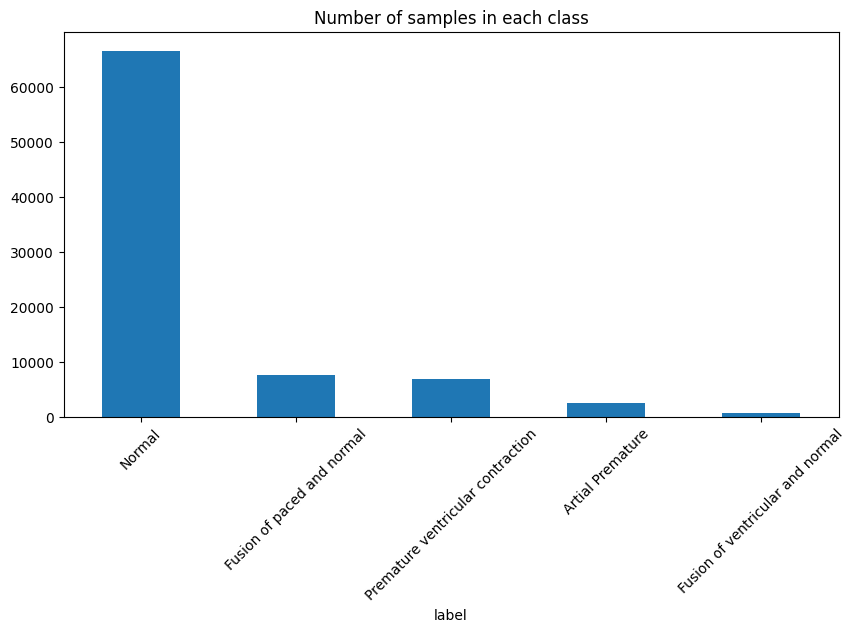

In [4]:
import random

df_mitbih_train = pd.read_csv("/home/ssk213/CSE_MSE_RXF131/cradle-members/sdle/ssk213/LLNL/classification_dataset/mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv("/home/ssk213/CSE_MSE_RXF131/cradle-members/sdle/ssk213/LLNL/classification_dataset/mitbih_test.csv", header = None)

print("Train Dataset")

print(df_mitbih_train.shape)
print(df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

zero_indices = df_mitbih[df_mitbih['label'] == 0].index

# Randomly select 20% of these indices to drop
indices_to_drop = np.random.choice(zero_indices, size=int(0.2 * len(zero_indices)), replace=False)

df_mitbih = df_mitbih.drop(indices_to_drop)
df_mitbih = df_mitbih.reset_index(drop=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

num_cols = df_mitbih.shape[1] - 1 

time = np.arange(0, num_cols) / 125
time = time * 1000
print("The last time value is : ", time[-1])

df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()
# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure 
plt.figure(figsize = (10, 5))
counts.plot(kind = "bar")
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

In the plot above, we see a very disproportionate number of each type of heartbeat 

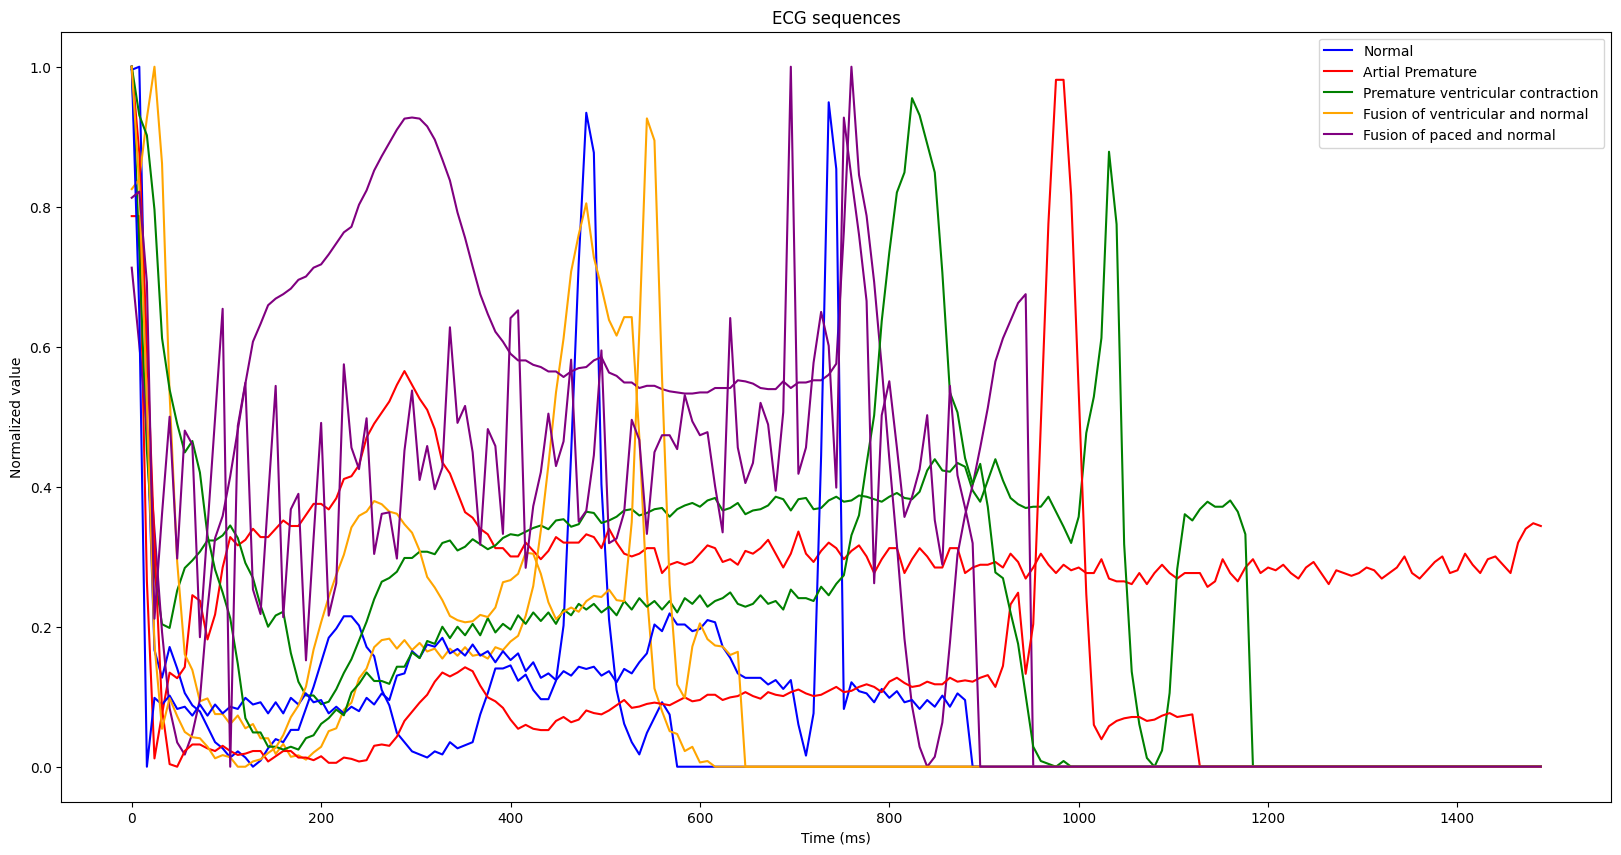

In [5]:
plt.figure(figsize = (20, 10))

colors = ["blue", "red", "green", "orange", "purple"]

for i in range(2):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])  

plt.legend()
plt.title("ECG sequences")
plt.ylabel("Normalized value")
plt.xlabel("Time (ms)")
plt.show()
plt.close()

# Data Preparation

In [6]:
from sklearn.model_selection import train_test_split

X = df_mitbih.iloc[:,:-1]
y = df_mitbih.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(67780, 187)
(67780,)
(8473, 187)
(8473,)
(8472, 187)
(8472,)


In [10]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
    raise SystemError('No GPU device found')
print('Found GPU at: {}'.format(device))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


2024-07-31 14:07:14.487213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:4a:00.0, compute capability: 8.9


# Model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 185, 32)           128       
                                                                 
 dropout_6 (Dropout)         (None, 185, 32)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 183, 32)           3104      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 91, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 89, 64)            6208      
                                                                 
 dropout_7 (Dropout)         (None, 89, 64)            0         
                                                      

None
Weights per each class
{0: 0.6359398925150869, 1: 5.471070644453055, 2: 6.104106628242075, 3: 15.919767004885381, 4: 55.23142112125163}
Epoch 1/50
2119/2119 [==============================] - 5s 2ms/step - loss: 3.5409 - accuracy: 0.4414 - val_loss: 1.0209 - val_accuracy: 0.5887
Epoch 2/50
2119/2119 [==============================] - 4s 2ms/step - loss: 1.7657 - accuracy: 0.6760 - val_loss: 0.7592 - val_accuracy: 0.7214
Epoch 3/50
2119/2119 [==============================] - 4s 2ms/step - loss: 1.2725 - accuracy: 0.7746 - val_loss: 0.6260 - val_accuracy: 0.7924
Epoch 4/50
2119/2119 [==============================] - 4s 2ms/step - loss: 1.0955 - accuracy: 0.8105 - val_loss: 0.5875 - val_accuracy: 0.7939
Epoch 5/50
2119/2119 [==============================] - 4s 2ms/step - loss: 0.9644 - accuracy: 0.8321 - val_loss: 0.3904 - val_accuracy: 0.8807
Epoch 6/50
2119/2119 [==============================] - 4s 2ms/step - loss: 0.8848 - accuracy: 0.8473 - val_loss: 0.3856 - val_accuracy: 0.

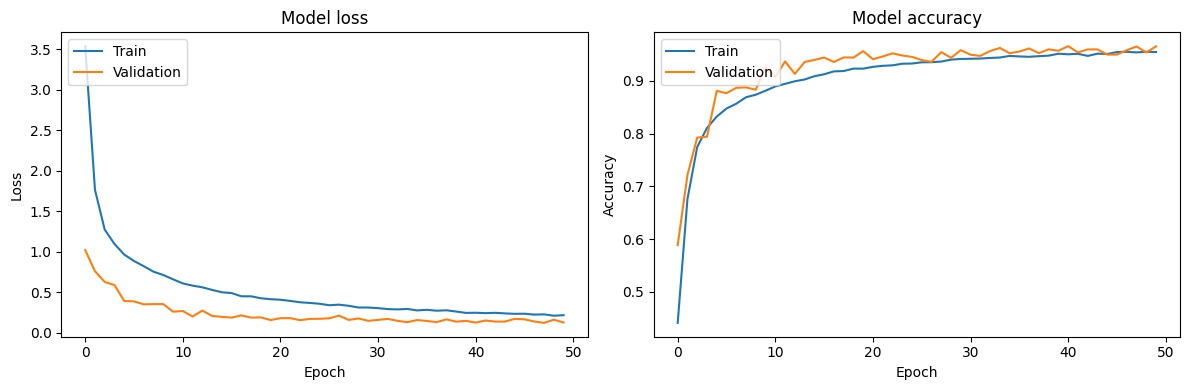

In [12]:
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# architecture
with tf.device('/gpu:0'):
    model = keras.Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(layers.Conv1D(32, 3, strides=1, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv1D(32, 3, strides=1, activation="relu"))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(64, 3, strides=1, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv1D(64, 3, strides=1, activation="relu"))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    print(model.summary())

# Making weights for each class
weight_0 = (1/counts.iloc[0]) * (len(df_mitbih)/2.0)
weight_1 = (1/counts.iloc[1]) * (len(df_mitbih)/2.0)
weight_2 = (1/counts.iloc[2]) * (len(df_mitbih)/2.0)
weight_3 = (1/counts.iloc[3]) * (len(df_mitbih)/2.0)
weight_4 = (1/counts.iloc[4]) * (len(df_mitbih)/2.0)

class_weight = {0: weight_0, 1: weight_1, 2: weight_2, 3: weight_3, 4: weight_4}
print("Weights per each class")
print(class_weight)

# loss/optimizer
loss = SparseCategoricalCrossentropy(from_logits=True)
optim = Adam(learning_rate=0.0001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

# training
# with tf.device('/GPU:0'):
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    class_weight=class_weight,
                    verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


plt.figure(figsize=(12, 4))

# Plot training and validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation acc values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()